# Obtaining thresholds and calibrating probabilities for Suicidal Ideation Model

In [193]:
import pip
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from numpy import mean
from numpy import std
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from matplotlib import pyplot
import xgboost as xgb
from sklearn.metrics import recall_score as recall
from sklearn.metrics import confusion_matrix
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
from sklearn.calibration import CalibratedClassifierCV as CCCV
InteractiveShell.ast_node_interactivity = "all"

In [194]:
#Dividing the training dataset using stratified split for threshold moving 
Xi=pd.read_csv('Xi.csv')
y=pd.read_csv('y_si.csv')
X55, X15, y55, y15=train_test_split(Xi, y, test_size=0.15, random_state=42, stratify=y)
X55.to_csv('X55_si.csv', index=False)
X15.to_csv('X15_si.csv', index=False)
y55.to_csv('y55_si.csv', index=False)
y15.to_csv('y15_si.csv', index=False)

In [137]:
y55=y55.values.flatten()
y15=y15.values.flatten()

In [138]:
np.average(y)

0.10771041789287816

## Logistic Regression

### Uncalibrated logistic regression

In [140]:
#Hyperparameter tuning for log regression
cv_inner=KFold(n_splits=3, shuffle=True, random_state=26)
space=dict()
space['solver']=['newton-cg', 'lbfgs', 'liblinear']
space['penalty']=['none', 'l1', 'l2', 'elasticnet']
space['C']=[100, 10, 1, 0.1, 0.01]
LR= LogisticRegression(random_state=26)
search=RandomizedSearchCV(LR, space, scoring='roc_auc', n_jobs=-1,n_iter=10, cv=cv_inner, refit=True)
#Configuring cross-valiation
cv_outer=KFold(n_splits=10, shuffle=True, random_state=26)

In [141]:
LR_proba=cross_val_predict(search, X55, y55, method='predict_proba', cv=cv_outer, n_jobs=-1)
LR_proba=LR_proba[:, 1]
print('Probs: %.3f (%.3f)' % (mean(LR_proba), std(LR_proba)) )

Probs: 0.115 (0.214)


### Calibrating logistic regression

In [142]:
#Calibrating the model
LR= LogisticRegression(random_state=26, n_jobs=-1)
space=dict()
space['solver']=['newton-cg', 'lbfgs', 'liblinear']
space['penalty']=['none', 'l1', 'l2', 'elasticnet']
space['C']=[100, 10, 1, 0.1, 0.01]
searchLR=RandomizedSearchCV(LR, space, scoring='roc_auc', n_jobs=-1,n_iter=30, refit=True, random_state=26)
searchLR.fit(X55, y55)

C:\Users\z5291979\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
85 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\z5291979\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\z5291979\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\z5291979\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise Val

RandomizedSearchCV(estimator=LogisticRegression(n_jobs=-1, random_state=26),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01],
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   random_state=26, scoring='roc_auc')

In [143]:
searchLR.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}

In [144]:
cLR=CCCV(searchLR.best_estimator_, method='isotonic')
cLR.fit(X55, y55)
LR_probac=cLR.predict_proba(X55)

C:\Users\z5291979\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\z5291979\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\z5291979\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\z5291979\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\z5291979\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'li

CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.1, n_jobs=-1,
                                                         penalty='l1',
                                                         random_state=26,
                                                         solver='liblinear'),
                       method='isotonic')

In [145]:
LR_probac=LR_probac[:, 1]
print('Probs: %.3f (%.3f)' % (mean(LR_probac), std(LR_probac)) )

Probs: 0.109 (0.100)


In [146]:
#Optimal threshold for the model using Youden's J statistic
from numpy import nanargmax
# get the best threshold
J = tpr - fpr
ix = nanargmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.116885


In [147]:
for i in np.arange(80, 100, 5):
    print("Top", 100-i, "% of predicted risk=", np.percentile(LR_probac, i) )

Top 20 % of predicted risk= 0.14822048793700862
Top 15 % of predicted risk= 0.17267649751792355
Top 10 % of predicted risk= 0.22993591766208396
Top 5 % of predicted risk= 0.32853124228712466


In [148]:
yprob=cLR.predict_proba(X15)

In [149]:
yprob=yprob[:, 1]
print('Probs: %.3f (%.3f)' % (mean(yprob), std(yprob)) )

Probs: 0.107 (0.092)


Text(0.5, 0, 'Predicted probability')

Text(0, 0.5, 'True probability')

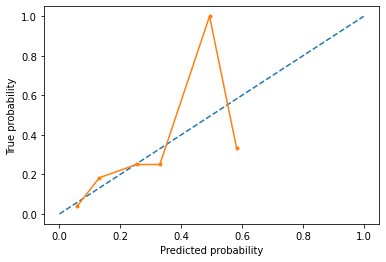

In [150]:
from sklearn.calibration import calibration_curve
# reliability diagram
fop, mpv = calibration_curve(y15, yprob, n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.xlabel('Predicted probability')
pyplot.ylabel('True probability')
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

In [151]:
roc_auc_score(y15, yprob)

0.7707115009746589

In [152]:
ypredcLR=np.where(yprob>0.17267649751792355, 1, 0)
f1_score(y15, ypredcLR)

0.29508196721311475

In [153]:
recall(y15, ypredcLR)

0.3333333333333333

In [154]:
ypredcLR=np.where(yprob>0.14822048793700862, 1, 0)
f1_score(y15, ypredcLR)

0.3561643835616438

In [155]:
recall(y15, ypredcLR)

0.48148148148148145

In [156]:
ypredcLR=np.where(yprob>0.116885, 1, 0)
f1_score(y15, ypredcLR)

0.3333333333333333

In [157]:
recall(y15, ypredcLR)

0.5925925925925926

## Random Forests

### Calibrated Random Forests

In [158]:
RF= RandomForestClassifier(random_state=26)
space=dict()
space['n_estimators']=[10, 50, 100, 250, 500]
space['max_features']=[10, 50, 200, 500]
space['min_samples_split']=[2, 10, 50]
searchRF=RandomizedSearchCV(RF, space, scoring='roc_auc', n_jobs=-1, n_iter=30, refit=True, random_state=26)

searchRF.fit(X55, y55)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=26), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'max_features': [10, 50, 200, 500],
                                        'min_samples_split': [2, 10, 50],
                                        'n_estimators': [10, 50, 100, 250,
                                                         500]},
                   random_state=26, scoring='roc_auc')

In [159]:
searchRF.best_params_

{'n_estimators': 50, 'min_samples_split': 50, 'max_features': 500}

In [160]:
cRF=CCCV(searchRF.best_estimator_, method='isotonic')
cRF.fit(X55, y55)
RF_probac=cRF.predict_proba(X55)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_features=500,
                                                             min_samples_split=50,
                                                             n_estimators=50,
                                                             random_state=26),
                       method='isotonic')

In [161]:
RF_probac=RF_probac[:, 1]
print('Probs: %.3f (%.3f)' % (mean(RF_probac), std(RF_probac)) )

Probs: 0.112 (0.164)


In [162]:
yprobRF=cRF.predict_proba(X15)
yprobRF=yprobRF[:, 1]
print('Probs: %.3f (%.3f)' % (mean(yprobRF), std(yprobRF)) )

Probs: 0.099 (0.131)


In [163]:
#Optimal threshold for the model using Youden's J statistic
fpr, tpr, thresholds=roc_curve(y55, RF_probac)
from numpy import nanargmax
# get the best threshold
J = tpr - fpr
ix = nanargmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.173486


In [166]:
roc_auc_score(y15, yprobRF)

0.8785737491877843

In [164]:
for i in np.arange(80, 100, 5):
    print("Top", 100-i, "% of predicted risk=", np.percentile(RF_probac, i) )

Top 20 % of predicted risk= 0.15102978825938979
Top 15 % of predicted risk= 0.18983720792902234
Top 10 % of predicted risk= 0.273130683825725
Top 5 % of predicted risk= 0.48255244755244747


In [165]:
ypredRFc=np.where(yprobRF>0.18983720792902234, 1, 0)
f1_score(y15, ypredRFc)

0.456140350877193

In [167]:
recall(y15, ypredRFc)

0.48148148148148145

In [168]:
#Specificity
tn, fp, fn, tp= confusion_matrix(y15, ypredRFc).ravel()
print(tn/(tn+fp))

0.9254385964912281


In [169]:
ypredRFc=np.where(yprobRF>0.15102978825938979, 1, 0)
f1_score(y15, ypredRFc)

0.5205479452054794

In [170]:
recall(y15, ypredRFc)

0.7037037037037037

In [171]:
#Specificity
tn, fp, fn, tp= confusion_matrix(y15, ypredRFc).ravel()
print(tn/(tn+fp))

0.881578947368421


In [172]:
ypredRFc=np.where(yprobRF>0.173486, 1, 0)
f1_score(y15, ypredRFc)

0.5074626865671642

In [173]:
recall(y15, ypredRFc)

0.6296296296296297

In [174]:
#Specificity
tn, fp, fn, tp= confusion_matrix(y15, ypredRFc).ravel()
print(tn/(tn+fp))

0.8991228070175439


Text(0.5, 0, 'Predicted probability')

Text(0, 0.5, 'True probability')

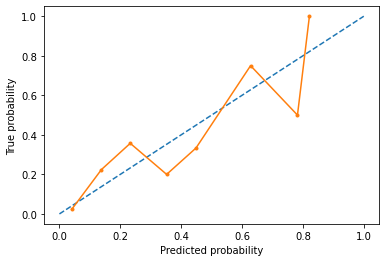

In [175]:
#Note: results below are unstable and change when rerun
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# reliability diagram
fop, mpv = calibration_curve(y15, yprobRF, n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.xlabel('Predicted probability')
pyplot.ylabel('True probability')
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

### Gradient boosting

In [176]:
from xgboost import XGBClassifier as xgb
#Configuring cross-val
cv_inner=KFold(n_splits=3, shuffle=True, random_state=26)
space=dict()
space['n_estimators']=[10, 100, 500, 1000]
space['max_depth']=[3, 6, 9, 12]
space['eta']=[0.001, 0.01, 0.1, 0.3, 1]
space['colsample_bytree']=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
space['subsample']=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
#Model 4: XGBoost
XGB=xgb(random_state=26)
cv=KFold(n_splits=10, random_state=26, shuffle=True)
searchXGB=RandomizedSearchCV(XGB, space, scoring='roc_auc', n_jobs=-1, n_iter=50, cv=cv_inner, refit=True)

searchXGB.fit(X55, y55)

C:\Users\z5291979\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\z5291979\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:44:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=26, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
     

In [177]:
searchXGB.best_params_

{'subsample': 0.6,
 'n_estimators': 1000,
 'max_depth': 3,
 'eta': 0.001,
 'colsample_bytree': 0.1}

In [178]:
cXGB=CCCV(searchXGB.best_estimator_, method='isotonic')
cXGB.fit(X55, y55)
XGB_probac=cXGB.predict_proba(X55)

C:\Users\z5291979\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\z5291979\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:44:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\z5291979\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\z5291979\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:45:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\z5291979\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\z5291979\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:45:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\z5291979\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\z5291979\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:45:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\z5291979\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\z5291979\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:45:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.1,
                                                    enable_categorical=False,
                                                    eta=0.001, gamma=0,
                                                    gpu_id=-1,
                                                    importance_type=None,
                                                    interaction_constraints='',
                                                    learning_rate=0.00100000005,
                                                    max_delta_step=0,
                                                    max_depth=3,
                                                    min_chil

In [179]:
XGB_probac=XGB_probac[:, 1]
print('Probs: %.3f (%.3f)' % (mean(XGB_probac), std(XGB_probac)) )

Probs: 0.111 (0.155)


In [180]:
#Optimal threshold for the model using Youden's J statistic
fpr, tpr, thresholds=roc_curve(y55, XGB_probac)
from numpy import nanargmax
# get the best threshold
J = tpr - fpr
ix = nanargmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.130436


In [181]:
for i in np.arange(80, 100, 5):
    print("Top", 100-i, "% of risk=", np.percentile(XGB_probac, i) )

Top 20 % of risk= 0.14892294943332676
Top 15 % of risk= 0.20001444727182383
Top 10 % of risk= 0.2709296762943268
Top 5 % of risk= 0.5138816273212425


In [182]:
yprobXGB=cXGB.predict_proba(X15)
yprobXGB=yprobXGB[:, 1]
print('Probs: %.3f (%.3f)' % (mean(yprobXGB), std(yprobXGB)) )

Probs: 0.103 (0.133)


In [183]:
ypredXGB=np.where(yprobXGB>0.20001444727182383, 1, 0)

In [184]:
np.average(ypredXGB)

0.13333333333333333

In [185]:
f1_score(y15, ypredXGB)

0.45901639344262296

In [186]:
recall(y15, ypredXGB)

0.5185185185185185

In [187]:
#Specificity
tn, fp, fn, tp= confusion_matrix(y15, ypredRFc).ravel()
print(tn/(tn+fp))

0.8991228070175439


In [188]:
roc_auc_score(y15, yprobXGB)

0.8677712800519819

In [189]:
ypredXGB=np.where(yprobXGB>0.130436, 1, 0)
f1_score(y15, ypredXGB)

0.4675324675324675

In [190]:
recall(y15, ypredXGB)

0.6666666666666666

In [191]:
#Specificity
tn, fp, fn, tp= confusion_matrix(y15, ypredRFc).ravel()
print(tn/(tn+fp))

0.8991228070175439


Text(0.5, 0, 'Predicted probability')

Text(0, 0.5, 'True probability')

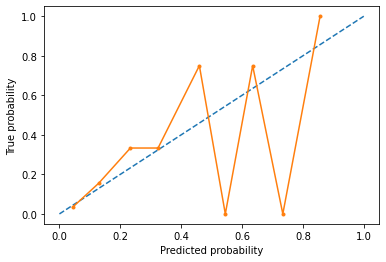

In [192]:
#Note: results below are unstable and change when rerun

from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# reliability diagram
fop, mpv = calibration_curve(y15, yprobXGB, n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.xlabel('Predicted probability')
pyplot.ylabel('True probability')
pyplot.plot(mpv, fop, marker='.')
pyplot.show()